In [1]:
%matplotlib inline
import torch
import numpy as np
import sys
sys.path.append('..')
import d2lzh_pytorch as d2l

y = 1.2x - 3.4x^2 + 5.6x^3 + 5 + a 
其中a是噪声，服从均值为0、标准差为0.01的正太分布
训练集和测试集的样本数均设为100

#### 生成数据集

In [4]:
n_train, n_test, true_w, true_b = 100, 100, [1.2, -3.4, 5.6], 5
features = torch.randn((n_train + n_test, 1))
print(features.size())
print(features[:2])
poly_features = torch.cat((features, torch.pow(features, 2), torch.pow(features, 3)), 1)
print(poly_features.size())
print(poly_features[:2])
labels = (true_w[0] * poly_features[:, 0] + true_w[1] * poly_features[:, 1]
          + true_w[2] * poly_features[:, 2] + true_b)
labels += torch.tensor(np.random.normal(0, 0.01, size=labels.size()), dtype=torch.float) # 加上噪声
print(labels[:2])

torch.Size([200, 1])
tensor([[0.9892],
        [1.4608]])
torch.Size([200, 3])
tensor([[0.9892, 0.9786, 0.9681],
        [1.4608, 2.1338, 3.1170]])
tensor([ 8.2858, 16.9518])


#### 定义、训练、测试模型

In [5]:
def semilogy(x_vals, y_vals, x_label, y_label,
             x2_vals=None, y2_vals=None, legend=None, figsize=(3.5, 2.5)):
    '''
    绘制半对数坐标图形，y轴使用了对数尺度
    '''
    d2l.set_figsize(figsize)
    d2l.plt.xlabel(x_label)
    d2l.plt.ylabel(y_label)
    d2l.plt.semilogy(x_vals, y_vals)
    if x2_vals and y2_vals:
        d2l.plt.semilogy(x2_vals, y2_vals, linestyle=':')
        d2l.plt.legend(legend)

In [8]:
num_epochs = 100
loss = torch.nn.MSELoss() # 使用平方损失函数

def fit_and_plot(train_features, test_features, train_labels, test_labels):
    '''
    多项式函数拟合的训练和测试
    '''
    #pytorch的nn.Linear已经将参数初始化了，不用手动初始化
    net = torch.nn.Linear(train_features.shape[-1], 1)
    batch_size = min(10, train_labels.shape[0])
    dataset = torch.utils.data.TensorDataset(train_features, train_labels)
    train_iter = torch.utils.data.DataLoader(dataset, batch_size, shuffle=True)
    optimizer = torch.optim.SGD(net.parameters(), lr=0.01)
    train_ls, test_ls = [], []
    for _ in range(num_epochs):
        for X, y in train_iter:
            l = loss(net(X), y.view(-1, 1)) # 计算loss
            optimizer.zero_grad() # 梯度清零
            l.backward() # 计算梯度
            optimizer.step() # 迭代模型参数
        train_labels = train_labels.view(-1, 1)
        test_labels = test_labels.view(-1, 1)
        train_ls.append(loss(net(train_features), train_labels).item()) #计算训练集总损失
        test_ls.append(loss(net(test_features), test_labels).item()) # 计算测试机总损失
    print('final epoch: train loss', train_ls[-1], 'test loss', test_ls[-1])
    # 绘制训练集和测试机的loss图
    semilogy(range(1, num_epochs + 1), train_ls, 'epochs', 'loss',
            range(1, num_epochs + 1), test_ls, ['train', 'test'])
    print('weight:', net.weight.data, '\nbias:', net.bias.data)

final epoch: train loss 9.80695549515076e-05 test loss 9.584090003045276e-05
weight: tensor([[ 1.1985, -3.3999,  5.6005]]) 
bias: tensor([5.0000])


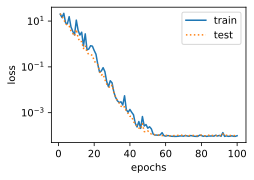

In [9]:
fit_and_plot(poly_features[:n_train, :], poly_features[n_train:, :],
            labels[:n_train], labels[n_train:])

#### 线性函数拟合（欠拟合）

线性模型(本实验中采用的线性回归模型)在非线性模型（本实验室中的三阶多项函数）上生成的数据集上容易欠拟合

final epoch: train loss 470.72601318359375 test loss 142.79098510742188
weight: tensor([[23.3243]]) 
bias: tensor([0.2239])


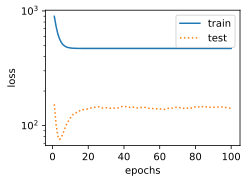

In [10]:
fit_and_plot(features[:n_train, :], features[n_train:, :],
            labels[:n_train], labels[n_train:])

#### 训练样本不足（过拟合）

final epoch: train loss 0.056853532791137695 test loss 83.21414947509766
weight: tensor([[2.2369, 2.1295, 2.6043]]) 
bias: tensor([1.1599])


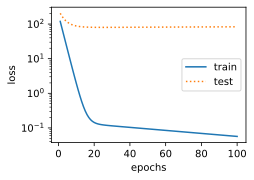

In [11]:
fit_and_plot(poly_features[0:2, :], poly_features[n_train:, :],
            labels[0:2], labels[n_train:])